# Dutch Crime Data: Not as bad as the news would have you believe

This project uses crime data from 2012-2024 collected from Politie Nederland and population data from the same period collected from the Centraal Bureau voor Statistiek (CBS) to calculate the total and violent crime rates per 1000 people at different geographic levels across the Netherlands.

<i><b>This project seeks to answer the following questions:</i></b>
1) Has crime in the Netherlands actually been increasing, as many people seem to believe?
2) Is there a difference in how violent crime rates have changed compared to total crime rates?
3) Which regions have the highest overall and violent crime rates?
4) Which of the major cities have historically had and currently have the highest crime rates?
5) Are there substantial differences in crime rates between two Dutch regions most often in the news for crime: the Randstad and Brabant?

<i><b>Key Performance Indicators (KPIs), each disaggregated on the national, regional and city level, include:</i></b>
- Total crime rate per 1000 people: total crime includes all crime categories listed in the crime data from Politie Nederland including violent crime, thievery, environmental crime, traffic crime, etc.
- Violent crime rate per 1000 people: violent crime is calculated based on crimes including physical violence (i.e. mugging, robbery, sex crimes, assault, threats, etc.)

<i><b>The project is organized in the following sections:</i></b>
- Data prep (including importing, inspecting, cleaning, transforming and merging the crime and population data)
- Analysis per question
- Correlation analysis of population vs. crime rates


# Packages

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import re
%pip install scipy
%pip install scikit-learn
from scipy.stats import shapiro, probplot, spearmanr
from sklearn.preprocessing import StandardScaler

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data prep

## Import data

In [146]:
## Import crime data from Politie
## Data extracted from: https://data.politie.nl/portal.html?_la=nl&_catalog=Politie&tableId=47013NED&_theme=114
## On: 21-12-2025
crime_data = 'allemisdrijven_pvgm_21122025.csv'
crime_df = pd.read_csv(crime_data, sep=';')
## Import crime metada from Politie
metadata = 'allemisdrijven_metadata_21122025.csv'
metadata_df = pd.read_csv(metadata, sep=';', header=1)

## Import population data from CBS
## Data extracted from: https://opendata.cbs.nl/#/CBS/nl/dataset/37230ned/table?ts=1766338546563
## On: 21-12-2025
popdata = 'bevolkingeindeperiod_jaren_22122025.csv'
popdata_df = pd.read_csv(popdata, sep=';', header=3)

In [147]:
## Inspect metadata
metadata_df.head(20)

,ID,Title,ShortTitle,Identifier,Summary,Modified,ReasonDelivery,ExplanatoryText,Language,Catalog,...,Period,ShortDescription,Description,DefaultPresentation,DefaultSelection,GraphTypes,OutputStatus,Source,MetaDataModified,SearchPriority
0,0,Geregistreerde misdrijven en aangiften; soort ...,Misdrijven en aangiften per gemeente,47013NED,"Geregistreerde misdrijven, aangiften en intern...",2025-12-15T02:00:00,ActualiseringBijzonder,NaN,nl,Politie,...,2012-2025,\nDeze tabel bevat cijfers over het aantal ger...,INHOUDSOPGAVE\n\n1. Toelichting\n2. Definities...,ts=1764853734957&graphtype=Table&r=RegioS&k=To...,$filter=((SoortMisdrijf eq '0.0.0 ')) and ((Pe...,"Table,Bar,Map",Regulier,&copy; Politie,2025-12-15T02:00:00,2.0
1,DataProperties,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID,Position,ParentID,Type,Key,Title,Description,ReleasePolicy,Datatype,Unit,...,Default,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,NaN,Dimension,SoortMisdrijf,Soort misdrijf,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,NaN,GeoDimension,RegioS,Regio's,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2,2,NaN,TimeDimension,Perioden,Perioden,NaN,TRUE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3,3,NaN,Topic,GeregistreerdeMisdrijven_1,Geregistreerde misdrijven,"Totaal van de geregistreerde misdrijven, bron ...",NaN,Long,aantal,...,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4,4,NaN,Topic,Aangiften_2,Aangiften,Aangiften betreffen geregistreerde misdrijven ...,NaN,Long,aantal,...,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5,5,NaN,Topic,Internetaangiften_3,Internetaangiften,Aangiften betreffen geregistreerde misdrijven ...,NaN,Long,aantal,...,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,SoortMisdrijf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
## Only need the first two columns with codes and their values
metadata_sub = metadata_df.iloc[9:,:2]
metadata_sub

,ID,Title
9,SoortMisdrijf,NaN
10,Key,Title
11,0.0.0,Totaal misdrijven
12,1.1.1,1.1.1 Diefstal/inbraak woning
13,1.1.2,1.1.2 Diefstal/inbraak box/garage/schuur
...,...,...
624,2025MM07,2025 juli
625,2025MM08,2025 augustus
626,2025MM09,2025 september
627,2025MM10,2025 oktober


In [149]:
## Inspect crime data
crime_df

,ID,SoortMisdrijf,RegioS,Perioden,GeregistreerdeMisdrijven_1
0,12,0.0.0,NL01,2012JJ00,1127693.0
1,25,0.0.0,NL01,2013JJ00,1078652.0
2,38,0.0.0,NL01,2014JJ00,1002641.0
3,51,0.0.0,NL01,2015JJ00,961210.0
4,64,0.0.0,NL01,2016JJ00,914206.0
...,...,...,...,...,...
506923,3980515,3.9.3,GM0999,2025MM07,NaN
506924,3980516,3.9.3,GM0999,2025MM08,NaN
506925,3980517,3.9.3,GM0999,2025MM09,NaN
506926,3980518,3.9.3,GM0999,2025MM10,NaN


In [150]:
## Inspect population data
popdata_df

,Regio's,Onderwerp,Unnamed: 2,2002,2003,2004,2005,2006,2007,2008,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Nederland,Bevolking aan het einde van de periode,aantal,16192572.0,16258032.0,16305526.0,16334210.0,16357992.0,16405399.0,16485787.0,...,16979120.0,17081507.0,17181084.0,17282163.0,17407585.0,17475415.0,17590672.0,17811291.0,17942942.0,18044027.0
1,Groningen (PV),Bevolking aan het einde van de periode,aantal,572997.0,574384.0,575072.0,574042.0,573614.0,573459.0,574092.0,...,583721.0,583581.0,582944.0,583990.0,585866.0,586937.0,590170.0,596075.0,601347.0,602833.0
2,Fryslân (PV),Bevolking aan het einde van de periode,aantal,639787.0,642066.0,642977.0,642230.0,642209.0,643189.0,644811.0,...,646040.0,646874.0,647268.0,647672.0,649957.0,651435.0,654019.0,659551.0,661904.0,664222.0
3,Drenthe (PV),Bevolking aan het einde van de periode,aantal,481254.0,482415.0,483369.0,484481.0,486197.0,488135.0,489918.0,...,488629.0,491792.0,492100.0,492167.0,493682.0,494771.0,497743.0,502051.0,504129.0,506529.0
4,Overijssel (PV),Bevolking aan het einde van de periode,aantal,1100677.0,1105512.0,1109432.0,1113529.0,1116374.0,1119994.0,1125435.0,...,1144280.0,1147687.0,1151501.0,1156431.0,1162406.0,1166533.0,1171910.0,1184333.0,1189033.0,1195789.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Zutphen,Bevolking aan het einde van de periode,aantal,36924.0,36552.0,36936.0,46642.0,46635.0,46762.0,46953.0,...,46997.0,47340.0,47537.0,47609.0,47934.0,48111.0,48330.0,48510.0,48752.0,49028.0
566,Zwartewaterland,Bevolking aan het einde van de periode,aantal,22206.0,22034.0,21877.0,21872.0,21919.0,21930.0,21944.0,...,22278.0,22309.0,22468.0,22503.0,22685.0,22823.0,23012.0,23368.0,23448.0,23507.0
567,Zwijndrecht,Bevolking aan het einde van de periode,aantal,41374.0,45384.0,45209.0,44588.0,44400.0,44472.0,44312.0,...,44454.0,44417.0,44586.0,44639.0,44737.0,44775.0,44789.0,45018.0,44874.0,44669.0
568,Zwolle,Bevolking aan het einde van de periode,aantal,109955.0,110880.0,111900.0,113078.0,114635.0,116365.0,117703.0,...,124896.0,125548.0,126116.0,127497.0,128840.0,129840.0,130668.0,132411.0,133141.0,133810.0


In [151]:
## Drop last row of population data, invalid
popdata_df = popdata_df[:-1]

## Drop onderwerp and unnamed columns, not needed
popdata_df = popdata_df.drop(columns=['Onderwerp', 'Unnamed: 2'])      

## Rename columns
popdata_df.rename(columns={"Regio's":"region"}, inplace=True)
popdata_df

,region,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Nederland,16192572.0,16258032.0,16305526.0,16334210.0,16357992.0,16405399.0,16485787.0,16574989.0,16655799.0,...,16979120.0,17081507.0,17181084.0,17282163.0,17407585.0,17475415.0,17590672.0,17811291.0,17942942.0,18044027.0
1,Groningen (PV),572997.0,574384.0,575072.0,574042.0,573614.0,573459.0,574092.0,576668.0,579036.0,...,583721.0,583581.0,582944.0,583990.0,585866.0,586937.0,590170.0,596075.0,601347.0,602833.0
2,Fryslân (PV),639787.0,642066.0,642977.0,642230.0,642209.0,643189.0,644811.0,646305.0,647282.0,...,646040.0,646874.0,647268.0,647672.0,649957.0,651435.0,654019.0,659551.0,661904.0,664222.0
3,Drenthe (PV),481254.0,482415.0,483369.0,484481.0,486197.0,488135.0,489918.0,490981.0,491411.0,...,488629.0,491792.0,492100.0,492167.0,493682.0,494771.0,497743.0,502051.0,504129.0,506529.0
4,Overijssel (PV),1100677.0,1105512.0,1109432.0,1113529.0,1116374.0,1119994.0,1125435.0,1130345.0,1134465.0,...,1144280.0,1147687.0,1151501.0,1156431.0,1162406.0,1166533.0,1171910.0,1184333.0,1189033.0,1195789.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,Zundert,20386.0,20431.0,20554.0,20797.0,20849.0,20947.0,21083.0,21025.0,21163.0,...,21488.0,21657.0,21525.0,21612.0,21829.0,21988.0,22260.0,22518.0,22553.0,22809.0
565,Zutphen,36924.0,36552.0,36936.0,46642.0,46635.0,46762.0,46953.0,46870.0,47084.0,...,46997.0,47340.0,47537.0,47609.0,47934.0,48111.0,48330.0,48510.0,48752.0,49028.0
566,Zwartewaterland,22206.0,22034.0,21877.0,21872.0,21919.0,21930.0,21944.0,21935.0,22018.0,...,22278.0,22309.0,22468.0,22503.0,22685.0,22823.0,23012.0,23368.0,23448.0,23507.0
567,Zwijndrecht,41374.0,45384.0,45209.0,44588.0,44400.0,44472.0,44312.0,44404.0,44445.0,...,44454.0,44417.0,44586.0,44639.0,44737.0,44775.0,44789.0,45018.0,44874.0,44669.0


In [152]:
## Check columns and dtypes
print(crime_df.dtypes)
print('--------------')
print(popdata_df.dtypes)

ID                              int64
SoortMisdrijf                  object
RegioS                         object
Perioden                       object
GeregistreerdeMisdrijven_1    float64
dtype: object
--------------
region     object
2002      float64
2003      float64
2004      float64
2005      float64
2006      float64
2007      float64
2008      float64
2009      float64
2010      float64
2011      float64
2012      float64
2013      float64
2014      float64
2015      float64
2016      float64
2017      float64
2018      float64
2019      float64
2020      float64
2021      float64
2022      float64
2023      float64
2024      float64
dtype: object


## Extract crime metadata

In [153]:
## Check unique codes per crime, region and period
print('Unique crime codes:')
print(crime_df['SoortMisdrijf'].unique())
print('Unique gemeente codes:')
print(crime_df['RegioS'].unique())
print('Unique year codes:')
print(crime_df['Perioden'].unique())

Unique crime codes:
['0.0.0 ' '1.1.1 ' '1.1.2 ' '1.2.1 ' '1.2.2 ' '1.2.3 ' '1.2.4 ' '1.2.5 '
 '1.3.1 ' '1.4.1 ' '1.4.2 ' '1.4.3 ' '1.4.4 ' '1.4.5 ' '1.4.6 ' '1.4.7 '
 '1.5.2 ' '1.6.1 ' '1.6.2 ' '1.6.3 ' '2.1.1 ' '2.2.1 ' '2.4.1 ' '2.4.2 '
 '2.5.1 ' '2.5.2 ' '2.6.1 ' '2.6.2 ' '2.6.3 ' '2.6.4 ' '2.6.5 ' '2.6.7 '
 '2.6.8 ' '2.6.9 ' '2.6.10' '2.6.11' '2.6.12' '2.6.13' '2.6.14' '2.7.2 '
 '2.7.3 ' '3.1.1 ' '3.1.2 ' '3.1.3 ' '3.2.1 ' '3.2.2 ' '3.3.2 ' '3.3.5 '
 '3.4.2 ' '3.5.2 ' '3.5.5 ' '3.6.4 ' '3.7.1 ' '3.7.2 ' '3.7.3 ' '3.7.4 '
 '3.9.1 ' '3.9.2 ' '3.9.3 ']
Unique gemeente codes:
['NL01  ' 'PV20  ' 'PV21  ' 'PV22  ' 'PV23  ' 'PV24  ' 'PV25  ' 'PV26  '
 'PV27  ' 'PV28  ' 'PV29  ' 'PV30  ' 'PV31  ' 'PV99  ' 'GM1680' 'GM0358'
 'GM0197' 'GM0059' 'GM0482' 'GM0613' 'GM0361' 'GM0141' 'GM0034' 'GM0484'
 'GM1723' 'GM1959' 'GM0060' 'GM0307' 'GM0362' 'GM0363' 'GM0200' 'GM0202'
 'GM0106' 'GM0743' 'GM0744' 'GM0308' 'GM0489' 'GM0203' 'GM0888' 'GM1954'
 'GM0889' 'GM1945' 'GM1724' 'GM0893' 'GM0373' 'GM074

In [154]:
crime_codes = list(crime_df['SoortMisdrijf'].unique())
gemeente_codes = list(crime_df['RegioS'].unique())
year_codes = list(crime_df['Perioden'].unique())
## Combined all codes in one list for iteration
code_list = crime_codes + gemeente_codes + year_codes
code_list

['0.0.0 ',
 '1.1.1 ',
 '1.1.2 ',
 '1.2.1 ',
 '1.2.2 ',
 '1.2.3 ',
 '1.2.4 ',
 '1.2.5 ',
 '1.3.1 ',
 '1.4.1 ',
 '1.4.2 ',
 '1.4.3 ',
 '1.4.4 ',
 '1.4.5 ',
 '1.4.6 ',
 '1.4.7 ',
 '1.5.2 ',
 '1.6.1 ',
 '1.6.2 ',
 '1.6.3 ',
 '2.1.1 ',
 '2.2.1 ',
 '2.4.1 ',
 '2.4.2 ',
 '2.5.1 ',
 '2.5.2 ',
 '2.6.1 ',
 '2.6.2 ',
 '2.6.3 ',
 '2.6.4 ',
 '2.6.5 ',
 '2.6.7 ',
 '2.6.8 ',
 '2.6.9 ',
 '2.6.10',
 '2.6.11',
 '2.6.12',
 '2.6.13',
 '2.6.14',
 '2.7.2 ',
 '2.7.3 ',
 '3.1.1 ',
 '3.1.2 ',
 '3.1.3 ',
 '3.2.1 ',
 '3.2.2 ',
 '3.3.2 ',
 '3.3.5 ',
 '3.4.2 ',
 '3.5.2 ',
 '3.5.5 ',
 '3.6.4 ',
 '3.7.1 ',
 '3.7.2 ',
 '3.7.3 ',
 '3.7.4 ',
 '3.9.1 ',
 '3.9.2 ',
 '3.9.3 ',
 'NL01  ',
 'PV20  ',
 'PV21  ',
 'PV22  ',
 'PV23  ',
 'PV24  ',
 'PV25  ',
 'PV26  ',
 'PV27  ',
 'PV28  ',
 'PV29  ',
 'PV30  ',
 'PV31  ',
 'PV99  ',
 'GM1680',
 'GM0358',
 'GM0197',
 'GM0059',
 'GM0482',
 'GM0613',
 'GM0361',
 'GM0141',
 'GM0034',
 'GM0484',
 'GM1723',
 'GM1959',
 'GM0060',
 'GM0307',
 'GM0362',
 'GM0363',
 'GM0200',
 'GM0202',

In [155]:
## Create dictionary with each code and its meaning
metadata_ids = metadata_sub.loc[:,'ID']
metadata_titles = metadata_sub.loc[:,'Title']

codes_dict = {}

for i, t in zip(metadata_ids, metadata_titles):
    if i in code_list:
        codes_dict[i] = t
        
codes_dict

{'0.0.0 ': 'Totaal misdrijven',
 '1.1.1 ': '1.1.1 Diefstal/inbraak woning',
 '1.1.2 ': '1.1.2 Diefstal/inbraak box/garage/schuur',
 '1.2.1 ': '1.2.1 Diefstal uit/vanaf motorvoertuigen',
 '1.2.2 ': '1.2.2 Diefstal van motorvoertuigen',
 '1.2.3 ': '1.2.3 Diefstal van brom-, snor-, fietsen',
 '1.2.4 ': '1.2.4 Zakkenrollerij',
 '1.2.5 ': '1.2.5 Diefstal af/uit/van ov. voertuigen',
 '1.3.1 ': '1.3.1 Ongevallen (weg)',
 '1.4.1 ': '1.4.1 Zedendelicten',
 '1.4.2 ': '1.4.2 Moord, doodslag',
 '1.4.3 ': '1.4.3 Openlijk geweld (persoon)',
 '1.4.4 ': '1.4.4 Bedreiging',
 '1.4.5 ': '1.4.5 Mishandeling',
 '1.4.6 ': '1.4.6 Straatroof',
 '1.4.7 ': '1.4.7 Overval',
 '1.5.2 ': '1.5.2 Diefstallen (water)',
 '1.6.1 ': '1.6.1 Brand/ontploffing',
 '1.6.2 ': '1.6.2 Overige vermogensdelicten',
 '1.6.3 ': '1.6.3 Mensenhandel',
 '2.1.1 ': '2.1.1 Drugs/drankoverlast',
 '2.2.1 ': '2.2.1 Vernieling cq. zaakbeschadiging',
 '2.4.1 ': '2.4.1 Burengerucht (relatieproblemen)',
 '2.4.2 ': '2.4.2 Huisvredebreuk',
 '2.5.1 

In [156]:
## Replace all codes with their meanings in the crime data
crime_df = crime_df.map(lambda x: codes_dict.get(x,x))
crime_df

,ID,SoortMisdrijf,RegioS,Perioden,GeregistreerdeMisdrijven_1
0,12,Totaal misdrijven,Nederland,2012,1127693.0
1,25,Totaal misdrijven,Nederland,2013,1078652.0
2,38,Totaal misdrijven,Nederland,2014,1002641.0
3,51,Totaal misdrijven,Nederland,2015,961210.0
4,64,Totaal misdrijven,Nederland,2016,914206.0
...,...,...,...,...,...
506923,3980515,3.9.3 Fraude (overig),Gemeenten; niet in te delen,2025 juli,NaN
506924,3980516,3.9.3 Fraude (overig),Gemeenten; niet in te delen,2025 augustus,NaN
506925,3980517,3.9.3 Fraude (overig),Gemeenten; niet in te delen,2025 september,NaN
506926,3980518,3.9.3 Fraude (overig),Gemeenten; niet in te delen,2025 oktober,NaN


In [157]:
## Strip code numbers from crime names
new_values = []
for i in list(crime_df['SoortMisdrijf']):
    i = re.sub(r'\d.', '', i)
    new_values.append(i)

crime_df['SoortMisdrijf'] = new_values

crime_df

,ID,SoortMisdrijf,RegioS,Perioden,GeregistreerdeMisdrijven_1
0,12,Totaal misdrijven,Nederland,2012,1127693.0
1,25,Totaal misdrijven,Nederland,2013,1078652.0
2,38,Totaal misdrijven,Nederland,2014,1002641.0
3,51,Totaal misdrijven,Nederland,2015,961210.0
4,64,Totaal misdrijven,Nederland,2016,914206.0
...,...,...,...,...,...
506923,3980515,Fraude (overig),Gemeenten; niet in te delen,2025 juli,NaN
506924,3980516,Fraude (overig),Gemeenten; niet in te delen,2025 augustus,NaN
506925,3980517,Fraude (overig),Gemeenten; niet in te delen,2025 september,NaN
506926,3980518,Fraude (overig),Gemeenten; niet in te delen,2025 oktober,NaN


In [158]:
## Rename columns
crime_df.rename(columns={'ID':'id','SoortMisdrijf':'crime_type', 'RegioS':'region', 'Perioden':'year', 'GeregistreerdeMisdrijven_1':'crime_count'},
                inplace=True)

crime_df

,id,crime_type,region,year,crime_count
0,12,Totaal misdrijven,Nederland,2012,1127693.0
1,25,Totaal misdrijven,Nederland,2013,1078652.0
2,38,Totaal misdrijven,Nederland,2014,1002641.0
3,51,Totaal misdrijven,Nederland,2015,961210.0
4,64,Totaal misdrijven,Nederland,2016,914206.0
...,...,...,...,...,...
506923,3980515,Fraude (overig),Gemeenten; niet in te delen,2025 juli,NaN
506924,3980516,Fraude (overig),Gemeenten; niet in te delen,2025 augustus,NaN
506925,3980517,Fraude (overig),Gemeenten; niet in te delen,2025 september,NaN
506926,3980518,Fraude (overig),Gemeenten; niet in te delen,2025 oktober,NaN


In [159]:
## Drop ros with 2025 values; not comparable to previous full year data
crime_df = crime_df[~crime_df['year'].str.contains('2025')]
crime_df['year'].unique()

array(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021', '2022', '2023', '2024'], dtype=object)

## Cleaning 

### Cleaning crime data

In [160]:
## Check unique values after extracting metadata
print(crime_df['crime_type'].unique())
print('-------')
print(crime_df['region'].unique())

['Totaal misdrijven' 'Diefstal/inbraak woning'
 'Diefstal/inbraak box/garage/schuur' 'Diefstal uit/vanaf motorvoertuigen'
 'Diefstal van motorvoertuigen' 'Diefstal van brom-, snor-, fietsen'
 'Zakkenrollerij' 'Diefstal af/uit/van ov. voertuigen' 'Ongevallen (weg)'
 'Zedendelicten' 'Moord, doodslag' 'Openlijk geweld (persoon)'
 'Bedreiging' 'Mishandeling' 'Straatroof' 'Overval' 'Diefstallen (water)'
 'Brand/ontploffing' 'Overige vermogensdelicten' 'Mensenhandel'
 'Drugs/drankoverlast' 'Vernieling cq. zaakbeschadiging'
 'Burengerucht (relatieproblemen)' 'Huisvredebreuk'
 'Diefstal/inbraak bedrijven enz.' 'Winkeldiefstal'
 'Inrichting Wet Milieubeheer' 'Bodem' 'Water' 'Afval' 'Bouwstoffen'
 'Mest' 'Transport gevaarlijke stoffen' 'Vuurwerk' ' Bestrijdingsmiddelen'
 ' Natuur en landschap' ' Ruimtelijke ordening' ' Dieren'
 ' Voedselveiligheid' 'Bijzondere wetten' 'Leefbaarheid (overig)'
 'Drugshandel' 'Mensensmokkel' 'Wapenhandel' 'Kinderporno'
 'Kinderprostitutie' 'Onder invloed (lucht)' '

In [161]:
## Drop rows where region values are Buitenland, Gemeenten; niet in te delen or 'Niet in te delen (PV)'
region_bool = ['Buitenland', 'Gemeenten; niet in te delen', 'Niet in te delen (PV)']
crime_df = crime_df[~(crime_df['region'].isin(region_bool))]
## Check they were dropped
crime_df['region'].unique()

array(['Nederland', 'Groningen (PV)', 'Fryslân (PV)', 'Drenthe (PV)',
       'Overijssel (PV)', 'Flevoland (PV)', 'Gelderland (PV)',
       'Utrecht (PV)', 'Noord-Holland (PV)', 'Zuid-Holland (PV)',
       'Zeeland (PV)', 'Noord-Brabant (PV)', 'Limburg (PV)',
       'Aa en Hunze', 'Aalsmeer', 'Aalten', 'Achtkarspelen',
       'Alblasserdam', 'Albrandswaard', 'Alkmaar', 'Almelo', 'Almere',
       'Alphen aan den Rijn', 'Alphen-Chaam', 'Altena', 'Ameland',
       'Amersfoort', 'Amstelveen', 'Amsterdam', 'Apeldoorn', 'Arnhem',
       'Assen', 'Asten', 'Baarle-Nassau', 'Baarn', 'Barendrecht',
       'Barneveld', 'Beek (L.)', 'Beekdaelen', 'Beesel', 'Berg en Dal',
       'Bergeijk', 'Bergen (L.)', 'Bergen (NH.)', 'Bergen op Zoom',
       'Berkelland', 'Bernheze', 'Best', 'Beuningen', 'Beverwijk',
       'De Bilt', 'Bladel', 'Blaricum', 'Bloemendaal',
       'Bodegraven-Reeuwijk', 'Boekel', 'Borger-Odoorn', 'Borne',
       'Borsele', 'Boxtel', 'Breda', 'Bronckhorst', 'Brummen', 'Brunssum',
 

In [162]:
## Check for null values
crime_df.isnull().sum()

id                  0
crime_type          0
region              0
year                0
crime_count    102642
dtype: int64

In [163]:
crime_df[crime_df['crime_count'].isnull()]

,id,crime_type,region,year,crime_count
9221,73337,Diefstal/inbraak woning,Ameland,2017,NaN
9227,73415,Diefstal/inbraak woning,Ameland,2023,NaN
14882,115778,Diefstal/inbraak woning,Schiermonnikoog,2014,NaN
14883,115791,Diefstal/inbraak woning,Schiermonnikoog,2015,NaN
14884,115804,Diefstal/inbraak woning,Schiermonnikoog,2016,NaN
...,...,...,...,...,...
506818,3979762,Fraude (overig),Zwartewaterland,2022,NaN
506819,3979775,Fraude (overig),Zwartewaterland,2023,NaN
506820,3979788,Fraude (overig),Zwartewaterland,2024,NaN
506843,3979955,Fraude (overig),Zwijndrecht,2023,NaN


In [164]:
## Drop all rows where crime_count value is null; can't use in calculations and can't reliably interpolate
crime_df = crime_df[~crime_df['crime_count'].isnull()]
## Check it worked
crime_df.isnull().sum()

id             0
crime_type     0
region         0
year           0
crime_count    0
dtype: int64

In [165]:
## Covnert numeric columns to integer
dtypes_dict = {'year':'int','crime_count':'int'}
crime_df = crime_df.astype(dtypes_dict)

In [166]:
crime_df.dtypes

id              int64
crime_type     object
region         object
year            int64
crime_count     int64
dtype: object

### Cleaning population data

In [167]:
## Check df
print(popdata_df.head(20))
print(f"Total number of regions included: {popdata_df.shape[0]}")

                region        2002        2003        2004        2005  \
0            Nederland  16192572.0  16258032.0  16305526.0  16334210.0   
1       Groningen (PV)    572997.0    574384.0    575072.0    574042.0   
2         Fryslân (PV)    639787.0    642066.0    642977.0    642230.0   
3         Drenthe (PV)    481254.0    482415.0    483369.0    484481.0   
4      Overijssel (PV)   1100677.0   1105512.0   1109432.0   1113529.0   
5       Flevoland (PV)    351680.0    359904.0    365859.0    370656.0   
6      Gelderland (PV)   1960422.0   1966929.0   1972010.0   1975704.0   
7         Utrecht (PV)   1152218.0   1162258.0   1171291.0   1180039.0   
8   Noord-Holland (PV)   2573120.0   2587265.0   2599103.0   2606584.0   
9    Zuid-Holland (PV)   3439982.0   3451942.0   3458381.0   3458875.0   
10        Zeeland (PV)    378348.0    379028.0    379978.0    380186.0   
11  Noord-Brabant (PV)   2400198.0   2406994.0   2411359.0   2415946.0   
12        Limburg (PV)   1141889.0   1

In [168]:
## Check null values in population df

## Calculate percentage missing population data per row
nulls_per_row = (popdata_df.isnull().sum(axis=1) / popdata_df.shape[1])*100

print(nulls_per_row[nulls_per_row > 0]) ## 271 regions have at least one missing value; all indiviudal municipalities 
                                        ## none of these are the country or PV region level (can tell by the indices)
print(f"Most missing: {nulls_per_row.max()}")
print(f"Amount of rows with >= 25% missing: {len(nulls_per_row[nulls_per_row >= 25])}")



14     25.000000
17     75.000000
18     58.333333
22     66.666667
28     70.833333
         ...    
556    83.333333
558    62.500000
559    50.000000
562    25.000000
563    33.333333
Length: 271, dtype: float64
Most missing: 91.66666666666666
Amount of rows with >= 25% missing: 230


In [169]:
## Calculate number of null values per row as new column
popdata_calcs = popdata_df.copy()
popdata_calcs['n_nulls'] = popdata_calcs.isnull().sum(axis=1)
## Calculate average population over time per row as new column
popdata_calcs['avg_pop'] = popdata_calcs.loc[:,'2012':'2024'].mean(axis=1, skipna=True)
popdata_calcs

,region,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2017,2018,2019,2020,2021,2022,2023,2024,n_nulls,avg_pop
0,Nederland,16192572.0,16258032.0,16305526.0,16334210.0,16357992.0,16405399.0,16485787.0,16574989.0,16655799.0,...,17181084.0,17282163.0,17407585.0,17475415.0,17590672.0,17811291.0,17942942.0,18044027.0,0,1.733118e+07
1,Groningen (PV),572997.0,574384.0,575072.0,574042.0,573614.0,573459.0,574092.0,576668.0,579036.0,...,582944.0,583990.0,585866.0,586937.0,590170.0,596075.0,601347.0,602833.0,0,5.881415e+05
2,Fryslân (PV),639787.0,642066.0,642977.0,642230.0,642209.0,643189.0,644811.0,646305.0,647282.0,...,647268.0,647672.0,649957.0,651435.0,654019.0,659551.0,661904.0,664222.0,0,6.514137e+05
3,Drenthe (PV),481254.0,482415.0,483369.0,484481.0,486197.0,488135.0,489918.0,490981.0,491411.0,...,492100.0,492167.0,493682.0,494771.0,497743.0,502051.0,504129.0,506529.0,0,4.946981e+05
4,Overijssel (PV),1100677.0,1105512.0,1109432.0,1113529.0,1116374.0,1119994.0,1125435.0,1130345.0,1134465.0,...,1151501.0,1156431.0,1162406.0,1166533.0,1171910.0,1184333.0,1189033.0,1195789.0,0,1.160739e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,Zundert,20386.0,20431.0,20554.0,20797.0,20849.0,20947.0,21083.0,21025.0,21163.0,...,21525.0,21612.0,21829.0,21988.0,22260.0,22518.0,22553.0,22809.0,0,2.186477e+04
565,Zutphen,36924.0,36552.0,36936.0,46642.0,46635.0,46762.0,46953.0,46870.0,47084.0,...,47537.0,47609.0,47934.0,48111.0,48330.0,48510.0,48752.0,49028.0,0,4.780008e+04
566,Zwartewaterland,22206.0,22034.0,21877.0,21872.0,21919.0,21930.0,21944.0,21935.0,22018.0,...,22468.0,22503.0,22685.0,22823.0,23012.0,23368.0,23448.0,23507.0,0,2.268254e+04
567,Zwijndrecht,41374.0,45384.0,45209.0,44588.0,44400.0,44472.0,44312.0,44404.0,44445.0,...,44586.0,44639.0,44737.0,44775.0,44789.0,45018.0,44874.0,44669.0,0,4.466277e+04


In [170]:
## Check patterns in average population for rows with at least one null value
print(popdata_calcs[popdata_calcs['n_nulls'] > 0][['region','avg_pop']])
print(f"Averge population of regions with at least one null value: {round(popdata_calcs[popdata_calcs['n_nulls'] > 0]['avg_pop'].mean(skipna=True),2)}")

                      region       avg_pop
14                   Aalburg  13017.285714
17                   Ter Aar           NaN
18                   Abcoude           NaN
22                  Alkemade           NaN
28                    Altena  57342.833333
..                       ...           ...
556                   Zelhem           NaN
558  Zevenhuizen-Moerkapelle           NaN
559                    Zijpe  11519.000000
562                 Zuidhorn  18834.714286
563                 Zuidplas  43675.692308

[271 rows x 2 columns]
Averge population of regions with at least one null value: 28212.46


In [171]:
## Most regions with null population values have low populations and therefore are unlikely to heavily skew crime figures
## More important to drop nulls and not interpolate that could introduce too much variation and errors in crime per capita calculations
## Drop all rows with at least one null value
print(f"Number of rows before dropping: {popdata_df.shape[0]}")
nullrow_counts = popdata_df.isnull().sum(axis=1)
nullrows_idx = list(nullrow_counts[nullrow_counts > 0].index)
popdata_df.drop(labels=nullrows_idx, axis=0, inplace=True)
print(f"Number of rows after dropping: {popdata_df.shape[0]}")


Number of rows before dropping: 569
Number of rows after dropping: 298


## Calculate crime rate per 1000 people

In [172]:
## Check df
crime_df.head()

,id,crime_type,region,year,crime_count
0,12,Totaal misdrijven,Nederland,2012,1127693
1,25,Totaal misdrijven,Nederland,2013,1078652
2,38,Totaal misdrijven,Nederland,2014,1002641
3,51,Totaal misdrijven,Nederland,2015,961210
4,64,Totaal misdrijven,Nederland,2016,914206


In [173]:
## Melt dataframe to match crime_df structure
popdata_long = pd.melt(
    popdata_df,
    id_vars=['region'],
    var_name='year',
    value_name='population'
)


In [174]:
popdata_long = popdata_long.astype({'year':'int','population':'int'})

popdata_long.head()

,region,year,population
0,Nederland,2002,16192572
1,Groningen (PV),2002,572997
2,Fryslân (PV),2002,639787
3,Drenthe (PV),2002,481254
4,Overijssel (PV),2002,1100677


In [175]:
## Check number of unique region names per dataframe
print(f"Number of unique regions in cleaned crime data: {crime_df['region'].nunique()}")
print(f"Number of unique regions in cleaned population data: {popdata_df['region'].nunique()}")

Number of unique regions in cleaned crime data: 355
Number of unique regions in cleaned population data: 298


In [176]:
## Merge crime and population dataframes by region and period
merged_df = crime_df.merge(popdata_long, on=['region','year'])
## Calculate misdrijven_per_cap column 
merged_df['crime_per_1000'] = round((merged_df['crime_count']/(merged_df['population']/1000)),2)
# merged_df.rename(columns={'population':'pop_per_1000'}, inplace=True)
# merged_df.head(50)
print(f"Final rows, columns: {merged_df.shape}")
print(f"Final number of regions included: {merged_df['region'].nunique()}")

Final rows, columns: (141796, 7)
Final number of regions included: 298


In [177]:
## Final data set with crime count, population and crime per 1000 people for each combination or region, year and crime type
merged_df.head()

,id,crime_type,region,year,crime_count,population,crime_per_1000
0,12,Totaal misdrijven,Nederland,2012,1127693,16779575,67.21
1,25,Totaal misdrijven,Nederland,2013,1078652,16829289,64.09
2,38,Totaal misdrijven,Nederland,2014,1002641,16900726,59.33
3,51,Totaal misdrijven,Nederland,2015,961210,16979120,56.61
4,64,Totaal misdrijven,Nederland,2016,914206,17081507,53.52


In [178]:
## Final check for remaining null values
merged_df.isnull().sum()

id                0
crime_type        0
region            0
year              0
crime_count       0
population        0
crime_per_1000    0
dtype: int64

## Create crime categories

In [179]:
## Check unique crime types
print(crime_df['crime_type'].unique())

['Totaal misdrijven' 'Diefstal/inbraak woning'
 'Diefstal/inbraak box/garage/schuur' 'Diefstal uit/vanaf motorvoertuigen'
 'Diefstal van motorvoertuigen' 'Diefstal van brom-, snor-, fietsen'
 'Zakkenrollerij' 'Diefstal af/uit/van ov. voertuigen' 'Ongevallen (weg)'
 'Zedendelicten' 'Moord, doodslag' 'Openlijk geweld (persoon)'
 'Bedreiging' 'Mishandeling' 'Straatroof' 'Overval' 'Diefstallen (water)'
 'Brand/ontploffing' 'Overige vermogensdelicten' 'Mensenhandel'
 'Drugs/drankoverlast' 'Vernieling cq. zaakbeschadiging'
 'Burengerucht (relatieproblemen)' 'Huisvredebreuk'
 'Diefstal/inbraak bedrijven enz.' 'Winkeldiefstal'
 'Inrichting Wet Milieubeheer' 'Bodem' 'Water' 'Afval' 'Bouwstoffen'
 'Mest' 'Transport gevaarlijke stoffen' 'Vuurwerk' ' Bestrijdingsmiddelen'
 ' Natuur en landschap' ' Ruimtelijke ordening' ' Dieren'
 ' Voedselveiligheid' 'Bijzondere wetten' 'Leefbaarheid (overig)'
 'Drugshandel' 'Mensensmokkel' 'Wapenhandel' 'Kinderporno'
 'Kinderprostitutie' 'Onder invloed (lucht)' '

In [180]:
total_crime =['Totaal misdrijven']

violent_crime = ['Zedendelicten','Moord, doodslag', 'Openlijk geweld (persoon)',
 'Bedreiging',
 'Mishandeling',
 'Straatroof',
 'Overval','Mensenhandel','Mensensmokkel', 'Kinderporno',
 'Kinderprostitutie', 'Wapenhandel']

explosive_crime = ['Brand/ontploffing', 'Vuurwerk']

env_crime = ['Inrichting Wet Milieubeheer', 'Bodem', 'Water', 'Afval', 'Bouwstoffen',
 'Mest', 'Transport gevaarlijke stoffen', 'Lucht (overig)',' Natuur en landschap', ' Dieren']

thievery = ['Diefstal/inbraak box/garage/schuur', 'Diefstal uit/vanaf motorvoertuigen', 'Diefstal van motorvoertuigen', 
'Diefstal van brom-, snor-, fietsen', 'Zakkenrollerij', 'Diefstal af/uit/van ov. voertuigen', 
'Diefstal/inbraak bedrijven enz.', 'Winkeldiefstal']

traffic = ['Ongevallen (weg)', 'Onder invloed (weg)', 'Weg (overig)' ]

## Create city & regional groupings

In [181]:
## Check gemeente names
crime_df['region'].unique()

array(['Nederland', 'Groningen (PV)', 'Fryslân (PV)', 'Drenthe (PV)',
       'Overijssel (PV)', 'Flevoland (PV)', 'Gelderland (PV)',
       'Utrecht (PV)', 'Noord-Holland (PV)', 'Zuid-Holland (PV)',
       'Zeeland (PV)', 'Noord-Brabant (PV)', 'Limburg (PV)',
       'Aa en Hunze', 'Aalsmeer', 'Aalten', 'Achtkarspelen',
       'Alblasserdam', 'Albrandswaard', 'Alkmaar', 'Almelo', 'Almere',
       'Alphen aan den Rijn', 'Alphen-Chaam', 'Altena', 'Ameland',
       'Amersfoort', 'Amstelveen', 'Amsterdam', 'Apeldoorn', 'Arnhem',
       'Assen', 'Asten', 'Baarle-Nassau', 'Baarn', 'Barendrecht',
       'Barneveld', 'Beek (L.)', 'Beekdaelen', 'Beesel', 'Berg en Dal',
       'Bergeijk', 'Bergen (L.)', 'Bergen (NH.)', 'Bergen op Zoom',
       'Berkelland', 'Bernheze', 'Best', 'Beuningen', 'Beverwijk',
       'De Bilt', 'Bladel', 'Blaricum', 'Bloemendaal',
       'Bodegraven-Reeuwijk', 'Boekel', 'Borger-Odoorn', 'Borne',
       'Borsele', 'Boxtel', 'Breda', 'Bronckhorst', 'Brummen', 'Brunssum',
 

In [182]:
## Create city groupings of interest for later analysis
brabant_cities = ['Eindhoven', 'Tilburg', 'Breda', "'s-Hertogenbosch"]
randstad_cities = ['Amsterdam', 'Utrecht (gemeente)', 'Rotterdam', "'s-Gravenhage (gemeente)"]
major_cities = ['Amsterdam', 'Haarlem', 'Utrecht (gemeente)', 'Rotterdam', "'s-Gravenhage (gemeente)", 
                   'Eindhoven', 'Tilburg', 'Breda', "'s-Hertogenbosch", 'Arnhem', 'Nijmegen', 'Groningen (gemeente)',
               'Maastricht', 'Enschede', 'Zwolle', 'Leeuwarden']

In [183]:
## Create separate dfs for different geographic levels (national, regions (PV) and gemeenten) for later analysis
## For total crime
regional_df = merged_df[(merged_df['region'].str.contains('(PV)')) & (merged_df['crime_type'] == 'Totaal misdrijven')]
national_df = merged_df[(merged_df['region'] == 'Nederland') & (merged_df['crime_type'] == 'Totaal misdrijven')]
cities_df = merged_df[((~merged_df['region'].isin(country_df['region'])) & (~merged_df['region'].isin(regions_df['region'])))
                        & (merged_df['crime_type'] == 'Totaal misdrijven')]

## For violent crime
dfr = merged_df[(merged_df['region'].str.contains('(PV)')) & (merged_df['crime_type'].isin(violent_crime))]
dfn = merged_df[(merged_df['region'] == 'Nederland') & (merged_df['crime_type'].isin(violent_crime))]
dfc = merged_df[((~merged_df['region'].isin(country_df['region'])) & (~merged_df['region'].isin(regions_df['region'])))
                        & (merged_df['crime_type'].isin(violent_crime))]

vc_dfs = []
for i in [dfn, dfr, dfc]:
    i = i.groupby(by=['region','year']).sum()
    i = (i
    .drop(columns='crime_type')
    .rename(columns={'crime_per_1000':'violentcrime_per_1000'})
        )
    vc_dfs.append(i)

national_violent = vc_dfs[0]
regional_violent = vc_dfs[1]
cities_violent = vc_dfs[2]

C:\Users\chels\AppData\Local\Temp\ipykernel_25084\178766189.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  regional_df = merged_df[(merged_df['region'].str.contains('(PV)')) & (merged_df['crime_type'] == 'Totaal misdrijven')]
C:\Users\chels\AppData\Local\Temp\ipykernel_25084\178766189.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dfr = merged_df[(merged_df['region'].str.contains('(PV)')) & (merged_df['crime_type'].isin(violent_crime))]


## Define functions

In [184]:
## Define function to calculate percentage change for 2012-2024 and 2019-2024
def percent_change(group):
    calc2012 = group[group['year'] == 2012]['crime_per_1000'].values[0]
    calc2019 = group[group['year'] == 2019]['crime_per_1000'].values[0]
    calc2024 = group[group['year'] == 2024]['crime_per_1000'].values[0]

    ## New column for change 2012-2024
    pct_change_full = round((calc2024 - calc2012) / calc2012 * 100, 2)
    ## New column for change 2019-2024
    pct_change_recent = round((calc2024 - calc2019) / calc2019 * 100, 2)

    return pd.Series({
        'pct_change_full': pct_change_full,
        'pct_change_recent': pct_change_recent
    })

# 1) Has crime in the Netherlands actually been increasing?

C:\Users\chels\anaconda3\Lib\site-packages\matplotlib\text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
C:\Users\chels\anaconda3\Lib\site-packages\matplotlib\text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


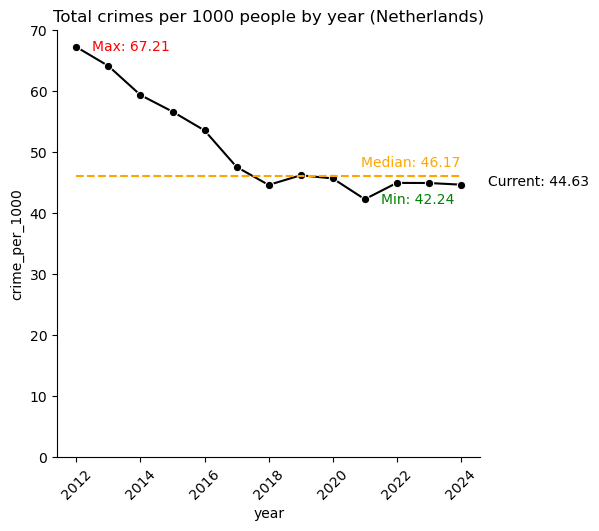

In [185]:
# Plot country-wide total crime per 1000
sns.relplot(
    data=national_df,
    x='year',
    y='crime_per_1000',
    marker='o',
    kind='line',
    color='black'
)

## Add median line
median_val = total_crimes_df['crime_per_1000'].median()
plt.hlines(y=round(median_val), xmin=2012, xmax=2024, colors='orange', linestyles='dashed', label='Median crime per 1000')

# Annotate min, max, median and current crime per 1000 values
min_val = total_crimes_df['crime_per_1000'].min()
max_val = total_crimes_df['crime_per_1000'].max()
current_val = total_crimes_df[total_crimes_df['year'] == 2024]['crime_per_1000'].values[0]

plt.text(
    x=total_crimes_df[total_crimes_df['crime_per_1000'] == min_val]['year'] + 0.5,  # Slightly offset for readability
    y=min_val,
    s=f'Min: {min_val:.2f}',
    ha='left',
    va='center',
    color='green'
)
plt.text(
    x= total_crimes_df[total_crimes_df['crime_per_1000'] == max_val]['year'] + 0.5,  # Slightly offset for readability
    y=max_val,
    s=f'Max: {max_val:.2f}',
    ha='left',
    va='center',
    color='red'
)
plt.text(
    x=2024,  # Place at the end of the x-axis
    y=median_val + 2, ## offset for readabililty
    s=f'Median: {median_val:.2f}',
    ha='right',
    va='center',
    color='orange'
)
plt.text(
    x=2028,  # Place at the end of the x-axis
    y=current_val + 0.5, ## offset for readabililty
    s=f'Current: {current_val:.2f}',
    ha='right',
    va='center',
    color='black'
)

plt.title('Total crimes per 1000 people by year (Netherlands)')
plt.xticks(rotation=45)
plt.ylim(0,70)
plt.show()


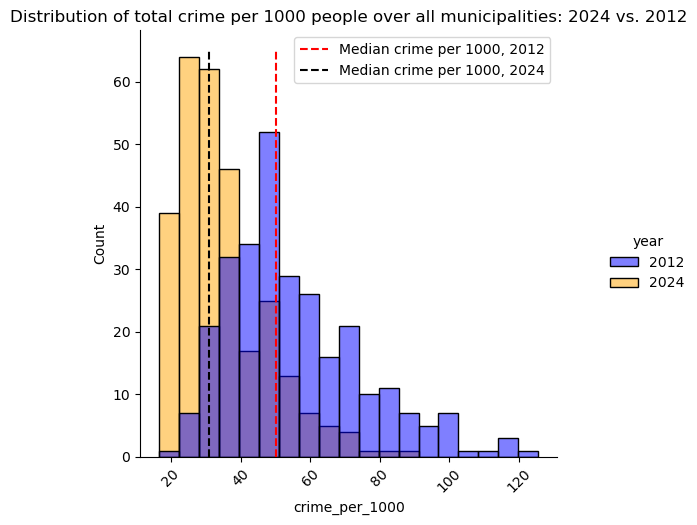

In [187]:
# Find the 10 cities with the highest crime in 2024 and in 2012
cities_compare = cities_df[ ((cities_df['year'] == 2024) | (cities_df['year'] == 2012)) ].sort_values(
    by=['crime_per_1000'], ascending=False)

# Histogram of distribution of total crime figures per gemeente in 2024 and 2012
sns.displot(data=cities_compare, x='crime_per_1000', hue='year', kind="hist", palette=['blue','orange'])

## Create median lines for each year's distribution
plt.vlines(x=cities_compare[cities_compare['year']==2012]['crime_per_1000'].median(), ymin=0, ymax=65, 
           colors='red', linestyles='dashed', label='Median crime per 1000, 2012')
plt.vlines(x=cities_compare[cities_compare['year']==2024]['crime_per_1000'].median(), ymin=0, ymax=65, 
           colors='black', linestyles='dashed', label='Median crime per 1000, 2024')

plt.legend()

plt.title('Distribution of total crime per 1000 people over all municipalities: 2024 vs. 2012')
plt.xticks(rotation=45)
plt.show()

# 2) Is there a difference in how violent crime rates have changed compared to total crime rates?

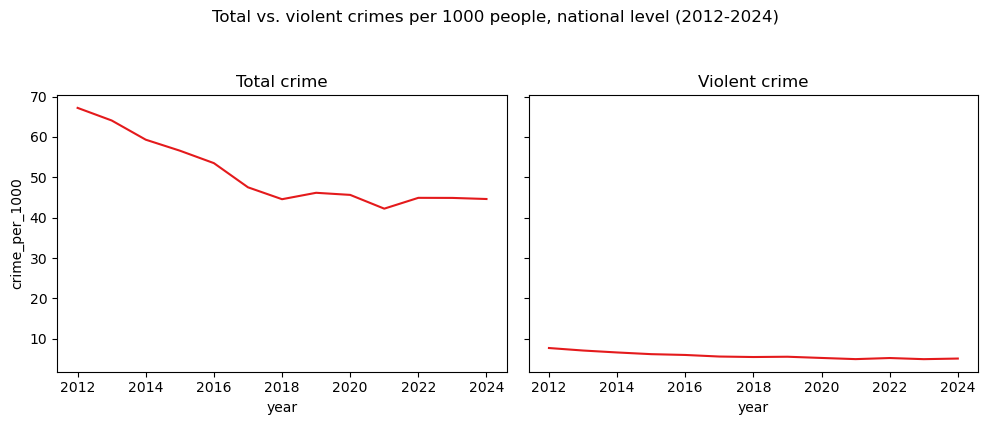

In [188]:
## Plot line chart of national violent crime rate 2012-2024; compare to national total crime rate 2012-2024

## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(width_ratios=[4, 4]), sharey=True, sharex=True)


## Plot national total crimes progression
sns.lineplot(data=national_df, 
             x='year', y='crime_per_1000', 
             ax=axs[0],
            legend=False)

## Plot national violent crime progression
sns.lineplot(data=national_violent, 
             x='year', y='violentcrime_per_1000',  
             ax=axs[1])

# Set titles
f.suptitle('Total vs. violent crimes per 1000 people, national level (2012-2024)', y=1.05)
axs[0].set_title('Total crime')
axs[1].set_title('Violent crime')


f.tight_layout()

# 3) Which regions have the highest overall and violent crime rates?

In [244]:
regional_grouped = regional_df.groupby(by=['region','year']).sum()
regional_concat = pd.concat([regional_grouped[['crime_per_1000']], regional_violent[['violentcrime_per_1000']]], axis=1)
regional_2024 = regional_concat.xs(2024, level='year')
regional_2024.sort_values(by='crime_per_1000', ascending=False)

,crime_per_1000,violentcrime_per_1000
region,,
Noord-Holland (PV),55.46,6.17
Zuid-Holland (PV),50.03,6.12
Limburg (PV),46.45,5.35
Noord-Brabant (PV),43.59,4.92
Groningen (PV),43.28,5.22
Utrecht (PV),42.59,3.84
Flevoland (PV),38.24,4.73
Overijssel (PV),36.79,4.02
Gelderland (PV),36.53,4.03


### !! ADD HERE
- Still need to add Datawrapper visualisations

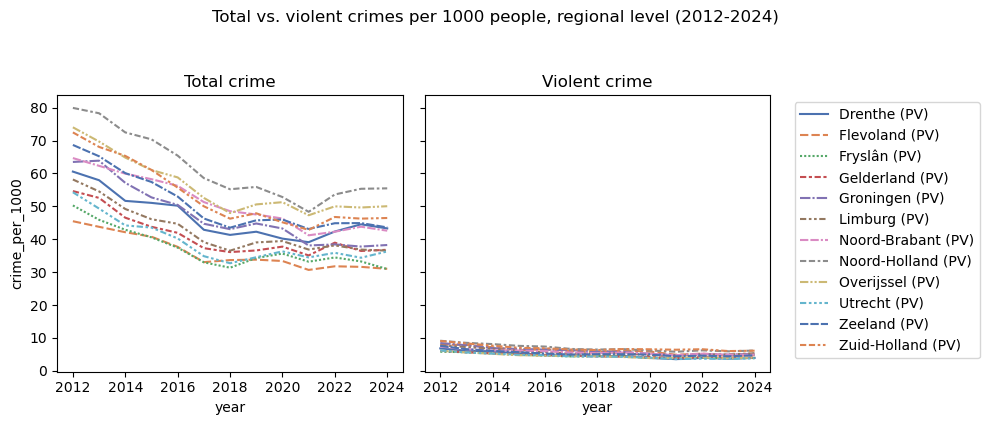

In [190]:
## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(width_ratios=[4, 4]), sharey=True, sharex=True)


## Plot national total crimes progression
sns.lineplot(data=regional_df, 
             x='year', y='crime_per_1000',
             hue='region', style='region',
             ax=axs[0], palette='deep',
            legend=False)

## Plot national violent crime progression
sns.lineplot(data=regional_violent, 
             x='year', y='violentcrime_per_1000',
             hue='region', style='region', palette='deep',
             ax=axs[1])

# Set titles
f.suptitle('Total vs. violent crimes per 1000 people, regional level (2012-2024)', y=1.05)
axs[0].set_title('Total crime')
axs[1].set_title('Violent crime')

# Move legend outside plots
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

f.tight_layout()

# 4) Which of the major cities have historically had and currently have the highest crime rates?

## Historically

In [191]:
# Find the top 20 cities with the highest overall average crime per 1000 people over time
mjcities_total = cities_df[(cities_df['crime_type'] == 'Totaal misdrijven') & (cities_df['region'].isin(major_cities))]

mjcities_grouped = mjcities_total[['region','crime_per_1000']].groupby(by=['region']).mean().sort_values(
    by=['crime_per_1000'], axis=0, ascending=False).round(2)
mjcities_grouped.rename(columns={'crime_per_1000':'Avg. total crime per 1000; 2012-2024'}, inplace=True)
## How can I rename the column to make clear they are averaged values??

mjcities_grouped

,Avg. total crime per 1000; 2012-2024
region,
Amsterdam,99.14
Rotterdam,87.59
Eindhoven,85.52
Utrecht (gemeente),79.04
Maastricht,77.98
's-Gravenhage (gemeente),76.94
Arnhem,75.89
Nijmegen,72.02
Groningen (gemeente),71.53


### Total crime progression over time: 2012 -2024

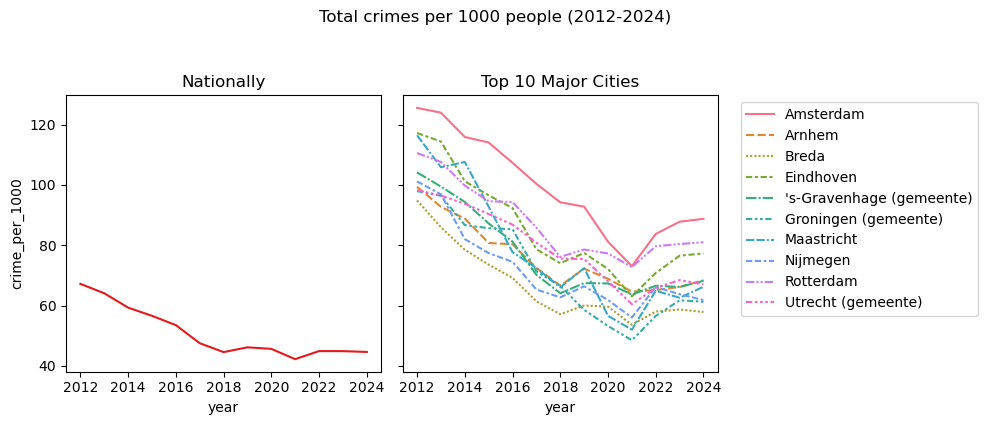

In [192]:
##Plot national & city trends from 2012 - 2024

## Subset top 10 cities in terms of historic average total crime rates per 1000 people
top10_gemeenten = cities_df[(cities_df['region'].isin(mjcities_grouped.index[:10])) & (cities_df['crime_type']=='Totaal misdrijven')]

## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(width_ratios=[4, 4]), sharey=True, sharex=True)


## Plot full timeline country level
sns.lineplot(data=national_df, 
             x='year', y='crime_per_1000', 
             # hue='region', style='region', 
             ax=axs[0],
            legend=False)

## Plot full timeline top 100 gemeenten
sns.lineplot(data=top10_gemeenten, 
             x='year', y='crime_per_1000', 
             hue='region', style='region', 
             ax=axs[1])

# Set titles
f.suptitle('Total crimes per 1000 people (2012-2024)', y=1.05)
axs[0].set_title('Nationally')
axs[1].set_title('Top 10 Major Cities')

# Move legend outside plots
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

f.tight_layout()

### Total crime progression over time: post-pandemic

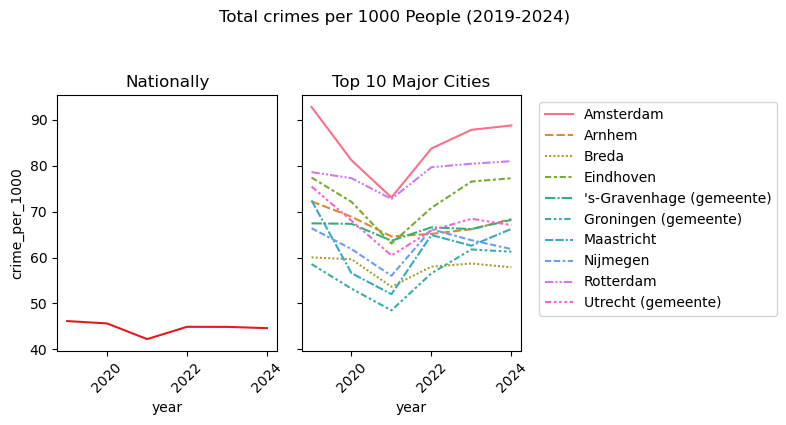

In [193]:
## Plot national & city trends from 2019-2024
last5_boolmask = range(2019,2025)

## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 4]), sharex=True, sharey=True)

## Plot country wide total crime 2019-2024
sns.lineplot(data=national_df[national_df['year'].isin(last5_boolmask)], 
             x='year', y='crime_per_1000', 
             # hue='region', style='region', 
             ax=axs[0],
            legend=False)


## Plot top 10 gemeenten 2019-2024
sns.lineplot(data=top10_gemeenten[top10_gemeenten['year'].isin(last5_boolmask)], 
             x='year', y='crime_per_1000', 
             hue='region', style='region', 
             ax=axs[1])

# Set titles
f.suptitle('Total crimes per 1000 People (2019-2024)', y=1.05)
axs[0].set_title('Nationally')
axs[1].set_title('Top 10 Major Cities')

## Rotate all x tick labels
for ax in axs:
    ax.tick_params(axis='x', rotation=45)

# Move legend outside plots
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

f.tight_layout()

In [194]:
## Create table with percentage changes in total crime for whole country + selected 10 cities over differnt time periods

## Apply the function to national data
country_pctchange = (
    national_df[['region', 'year', 'crime_per_1000']]
    .sort_values(by='year')
    .groupby('region')
    .apply(percent_change)
    .reset_index()
)

## Apply percent_change function to top 10 major cities data
top10_pctchange = (
    top10_gemeenten[['region', 'year', 'crime_per_1000']]
    .sort_values(by='year')
    .groupby('region')
    .apply(percent_change)
    .reset_index()
)

## Concat both into new dataframe
compare_pctchange = pd.concat([country_pctchange, top10_pctchange], axis=0).sort_values(by='pct_change_recent', ascending=False)
compare_pctchange.rename(columns={'pct_change_full':'% change 2012-2024', 'pct_change_recent':'% change 2019-2024'}, inplace=True)
compare_pctchange

C:\Users\chels\AppData\Local\Temp\ipykernel_25084\1102376986.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(percent_change)
C:\Users\chels\AppData\Local\Temp\ipykernel_25084\1102376986.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(percent_change)


,region,% change 2012-2024,% change 2019-2024
5,Groningen (gemeente),-37.44,4.61
8,Rotterdam,-26.75,3.04
0,'s-Gravenhage (gemeente),-34.52,1.11
4,Eindhoven,-34.08,-0.19
0,Nederland,-33.60,-3.34
3,Breda,-39.00,-3.60
1,Amsterdam,-29.30,-4.34
2,Arnhem,-31.20,-5.33
7,Nijmegen,-38.87,-6.84
6,Maastricht,-43.12,-8.56


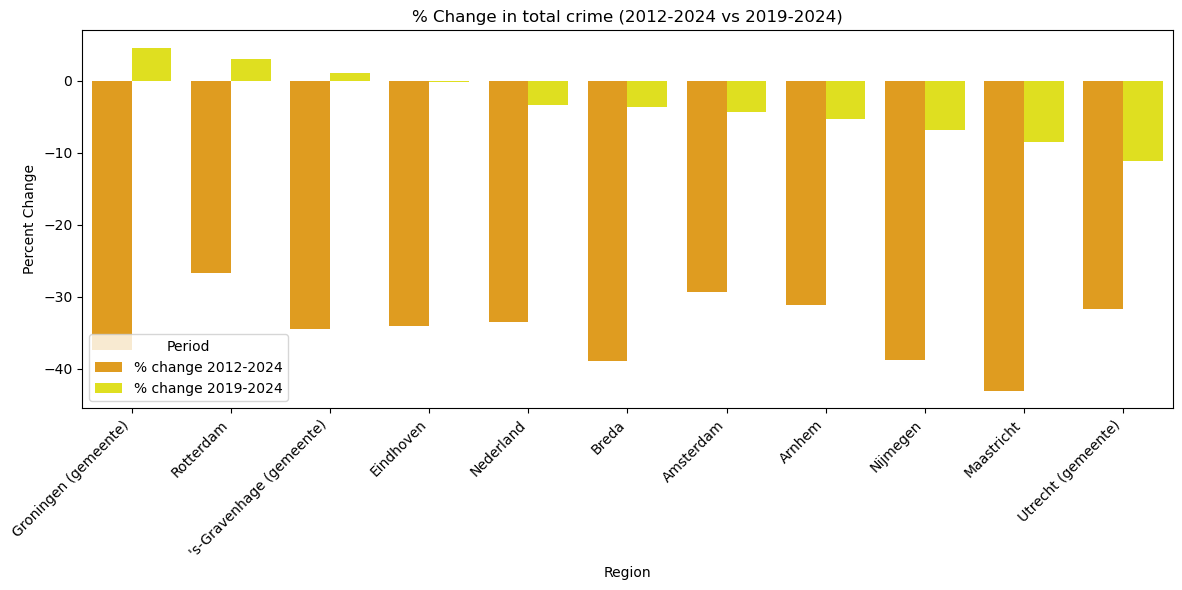

In [195]:
## Plot grouped bar chart of percentage change for national compared to top 10 cities major cities in average crime

# Reshape the data
pctchange_long = compare_pctchange.melt(id_vars='region', var_name='period', value_name='percent_change')

# Create the barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=pctchange_long,
    x='region',
    y='percent_change',
    hue='period',
    palette=['orange', 'yellow']
)



plt.title('% Change in total crime (2012-2024 vs 2019-2024)')
plt.xlabel('Region')
plt.ylabel('Percent Change')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Period')
plt.tight_layout()
plt.show()

### Total v. violent crime over time

In [208]:
mjc_violent10 = violent_majorcities[violent_majorcities['region'].isin(top10_gemeenten['region'])][['region','year','violentcrime_per_1000']]

top10_select = top10_gemeenten[['region','year','crime_per_1000']]

result = pd.merge(
    top10_select,
    mjc_violent10,
    on=['region', 'year'],
    how='outer')

result

,region,year,crime_per_1000,violentcrime_per_1000
0,'s-Gravenhage (gemeente),2012,104.16,12.90
1,'s-Gravenhage (gemeente),2013,99.46,12.45
2,'s-Gravenhage (gemeente),2014,94.37,11.60
3,'s-Gravenhage (gemeente),2015,87.24,10.28
4,'s-Gravenhage (gemeente),2016,81.22,9.65
...,...,...,...,...
125,Utrecht (gemeente),2020,68.03,5.87
126,Utrecht (gemeente),2021,60.45,5.14
127,Utrecht (gemeente),2022,65.90,5.60
128,Utrecht (gemeente),2023,68.45,5.26


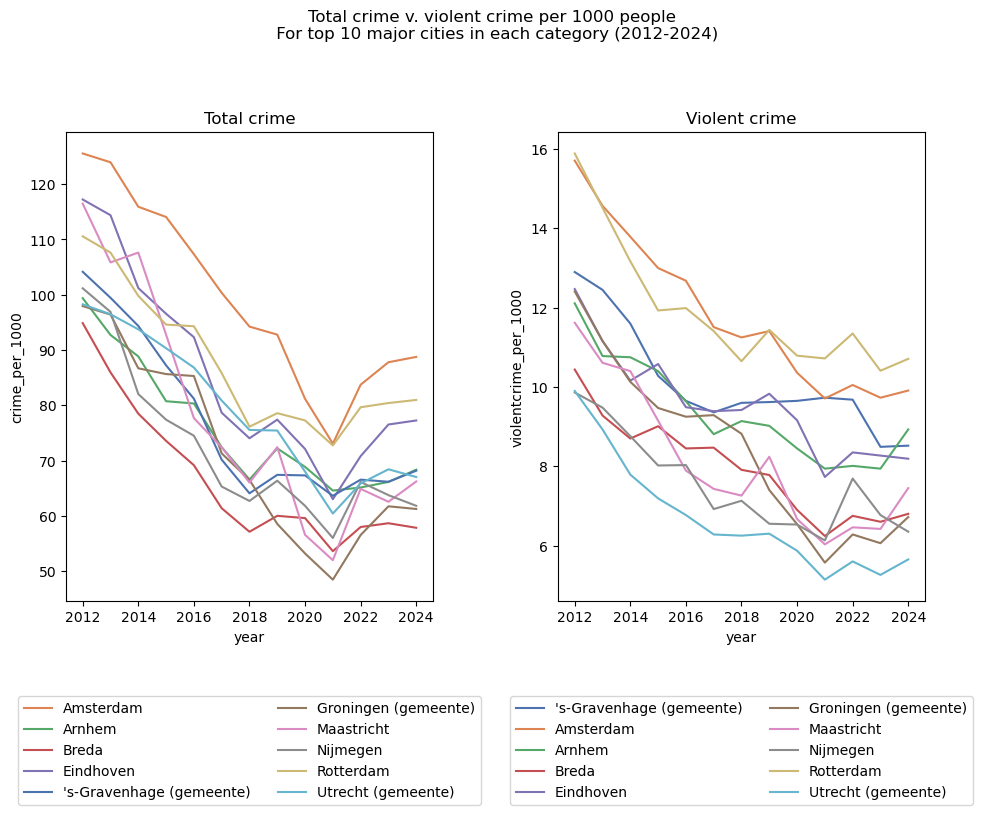

In [235]:
## Compare progression over time for total crime v. violent crime for 10 major cities
mjc_violent10 = violent_majorcities[violent_majorcities['region'].isin(top10_gemeenten['region'])][['region','year','violentcrime_per_1000']]

## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw=dict(width_ratios=[4, 4]), sharex=True)

# Define a consistent color palette for regions
regions = sorted(pd.unique(top10_gemeenten['region']))
palette = sns.color_palette('deep', n_colors=len(regions))
region_to_color = dict(zip(regions, palette))

# Plot full timeline top 10 major cities for total crime
sns.lineplot(
    data=top10_gemeenten,
    x='year',
    y='crime_per_1000',
    hue='region',
    palette=region_to_color,
    ax=axs[0],
    legend=True
)

# Plot full timeline top 10 major cities for violent crime
mjc_violent10 = violent_majorcities[violent_majorcities['region'].isin(top10_gemeenten['region'])]

sns.lineplot(
    data=mjc_violent10,
    x='year',
    y='violentcrime_per_1000',
    hue='region',
    ax=axs[1],
    legend=True, 
    palette=region_to_color
)

# Set titles
f.suptitle('Total crime v. violent crime per 1000 people \n For top 10 major cities in each category (2012-2024)', y=1.05)
axs[0].set_title('Total crime')
axs[1].set_title('Violent crime')

# Move legend outside plots
axs[0].legend(
    bbox_to_anchor=(0.5, -0.2),  # (x, y) coordinates relative to the axes
    loc='upper center',          # Location of the legend's anchor point
    ncol=2,                      # Number of columns in the legend (optional)
    borderaxespad=0.1            # Padding between the legend and the axes
)
axs[1].legend(
    bbox_to_anchor=(0.5, -0.2),  # (x, y) coordinates relative to the axes
    loc='upper center',          # Location of the legend's anchor point
    ncol=2,                      # Number of columns in the legend (optional)
    borderaxespad=0.1            # Padding between the legend and the axes
)

f.tight_layout()
plt.show()


## In 2024

In [227]:
## Subset top 10 cities for total crime and for violent crime in 2024
top10_2024 = cities_df[cities_df['year']==2024].sort_values(by=['crime_per_1000'], ascending=False).head(10)
top10_2024 = top10_2024[['year','region','crime_per_1000']].reset_index(drop=True)
violent10_2024 = (
    cities_violent.xs(2024, level='year')[['violentcrime_per_1000']]
    .sort_values(by='violentcrime_per_1000', ascending=False)
    .head(10)
)

### Current hotspots

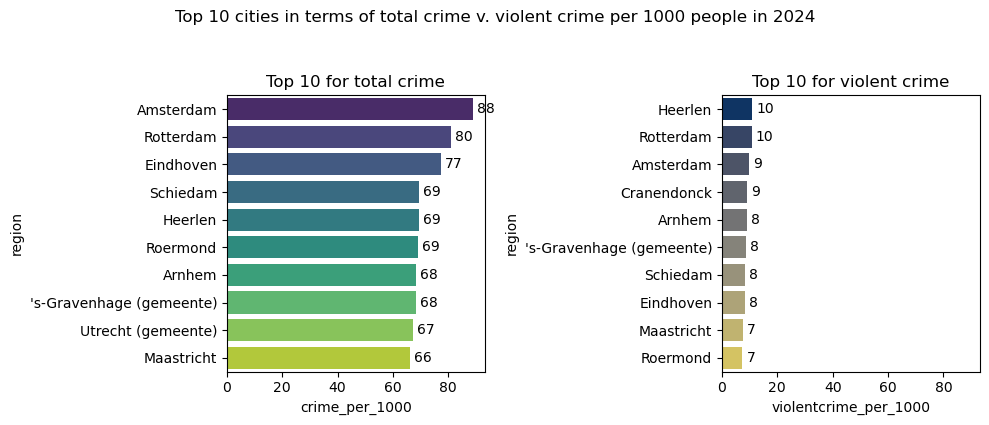

In [228]:
## Compare bar charts of top 10 cities in 2024 for total crime vs. violent crime

## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(width_ratios=[4, 4]), sharex=True)

## Plot bar chart of top 10 cities in terms of total crime 2024
sns.barplot(data=top10_2024,
            x='crime_per_1000',
            y='region',
            hue='region', palette='viridis',
                ax=axs[0],
                legend=False)
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%d', label_type='edge', padding=3)


sns.barplot(data=violent10_2024,
            x='violentcrime_per_1000',
            y='region',
            hue='region',
                ax=axs[1], legend=False,
           palette='cividis')
for container in axs[1].containers:
    axs[1].bar_label(container, fmt='%d', label_type='edge', padding=3)

# Set titles
f.suptitle('Top 10 cities in terms of total crime v. violent crime per 1000 people in 2024', y=1.05)
axs[0].set_title('Top 10 for total crime')
axs[1].set_title('Top 10 for violent crime')


f.tight_layout()
plt.show()


### Largest percent increases

In [240]:
## Apply percent change function to national data
country_pctchange = (
    national_df[['region', 'year', 'crime_per_1000']]
    .sort_values(by='year')
    .groupby('region')
    .apply(percent_change)
    .reset_index()
)


## Apply percent_change function to calculate which cities have experienced the sharpest increase in total crime
total_pctchange = (
    cities_df[['region', 'year', 'crime_per_1000']]
    .sort_values(by='year')
    .groupby('region')
    .apply(percent_change)
    .reset_index()
    .sort_values(by='pct_change_recent', ascending=False)
    .head(10)
)


## Concat both into new dataframe
compare_pctchange = pd.concat([country_pctchange, total_pctchange], axis=0).sort_values(by='pct_change_recent', ascending=False)
compare_pctchange.rename(columns={'pct_change_full':'% change 2012-2024', 'pct_change_recent':'% change 2019-2024'}, inplace=True)
compare_pctchange


C:\Users\chels\AppData\Local\Temp\ipykernel_25084\1644517021.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(percent_change)
C:\Users\chels\AppData\Local\Temp\ipykernel_25084\1644517021.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(percent_change)


,region,% change 2012-2024,% change 2019-2024
240,Veere,-16.71,50.12
104,Heemstede,-19.79,30.33
28,Bergen (L.),-8.29,29.80
129,Katwijk,-16.38,28.92
190,Reimerswaal,-21.81,27.46
37,Bloemendaal,-31.65,25.58
263,Wierden,-11.92,24.89
102,Hattem,-26.31,21.81
169,Oegstgeest,-16.11,20.58
110,Hellendoorn,-27.29,20.20


# 5) Are there substantial differences in crime rates between two Dutch regions most often in the news for crime: the Randstad and Brabant?

### Historically

In [135]:
## Table of average crime per 1000 in each year per city grouping
bvr_groups = cities_df[(cities_df['crime_type'] == 'Totaal misdrijven') &
((cities_df['region'].isin(brabant_cities))|(cities_df['region'].isin(randstad_cities)))]

bvr_groups['city_group'] = np.where(
    bvr_groups['region'].isin(brabant_cities), 'Brabant',
    np.where(bvr_groups['region'].isin(randstad_cities), 'Randstad', None)
)

bvr_grouped = bvr_groups[['city_group','year','crime_per_1000']].groupby(by=['city_group', 'year']).mean()
round(bvr_grouped,2)

C:\Users\chels\AppData\Local\Temp\ipykernel_25084\2542581396.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bvr_groups['city_group'] = np.where(


crime_per_1000
city_group year                
Brabant    2012           97.29
           2013           92.79
           2014           84.72
           2015           80.00
           2016           74.37
           2017           66.34
           2018           61.90
           2019           63.86
           2020           61.96
           2021           56.89
           2022           61.56
           2023           62.90
           2024           61.43
Randstad   2012          109.64
           2013          106.88
           2014          100.96
           2015           96.56
           2016           92.43
           2017           84.32
           2018           77.52
           2019           78.58
           2020           73.46
           2021           67.49
           2022           73.97
           2023           75.72
           2024           76.26

In [136]:
## Table of average crime per 1000 in each year per city grouping
bvr_violent = cities_violent[((cities_violent['region'].isin(brabant_cities))|(cities_violent['region'].isin(randstad_cities)))]

bvr_violent['city_group'] = np.where(
    bvr_violent['region'].isin(brabant_cities), 'Brabant',
    np.where(bvr_violent['region'].isin(randstad_cities), 'Randstad', None)
)

KeyError: 'region'

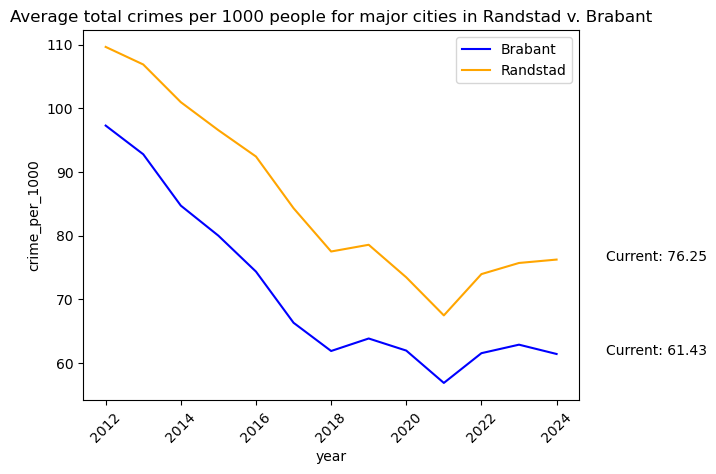

In [54]:
## Line chart of the average of total crime for each city group (Brabant vs. Randstad) over time
sns.lineplot(data=bvr_grouped,
           x='year',
           y='crime_per_1000',
           hue='city_group',
            palette=['blue','orange'])

current_randstad = bvr_grouped.loc[('Randstad', 2024)].values[0]
current_brabant = bvr_grouped.loc[('Brabant', 2024)].values[0]

plt.text(
    x=2028,  # Place at the end of the x-axis
    y=current_randstad + 0.5, ## offset for readabililty
    s=f'Current: {current_randstad:.2f}',
    ha='right',
    va='center',
    color='black'
)

plt.text(
    x=2028,  # Place at the end of the x-axis
    y=current_brabant + 0.5, ## offset for readabililty
    s=f'Current: {current_brabant:.2f}',
    ha='right',
    va='center',
    color='black'
)

plt.title('Average total crimes per 1000 people for major cities in Randstad v. Brabant')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()


Text(0.5, 1.05, 'Total crimes per 1000 people for each major city in Randstad v. Brabant\n(2012-2024)')

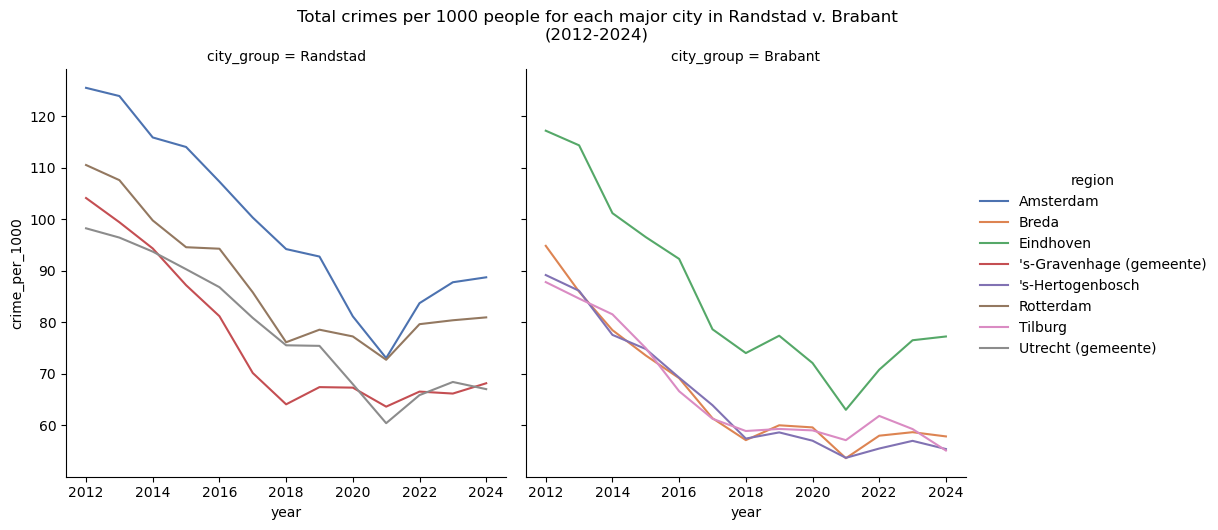

In [55]:
g = sns.relplot(data=bvr_groups, x="year", y="crime_per_1000", hue='region', col="city_group", kind='line', palette='deep')
g.set_axis_labels('year', 'crime_per_1000')
g.fig.suptitle(
    'Total crimes per 1000 people for each major city in Randstad v. Brabant\n(2012-2024)',
    y=1.05  # Adjust the vertical position of the title if needed
)

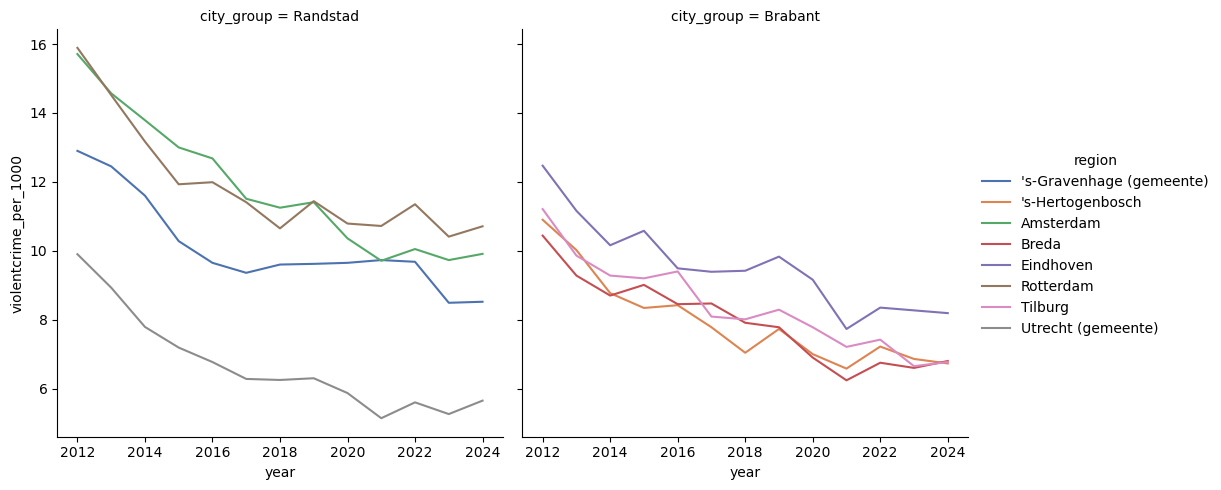

In [73]:
g = sns.relplot(data=bvr_violent, x="year", y="violentcrime_per_1000", hue='region', col="city_group", kind='line',palette='deep')
g.set_axis_labels('year', 'violentcrime_per_1000')

In [56]:
## Table of percent change in total crime for each city, from 2012-2024 and from 2019-2024
## Apply percent_change function to top 10 major cities data
bvr_pctchange = (
    bvr_groups[['region', 'year', 'crime_per_1000']]
    .sort_values(by='year')
    .groupby('region')
    .apply(percent_change)
    .reset_index()
)

bvr_pctchange.sort_values(by='pct_change_recent',ascending=False)

C:\Users\chels\AppData\Local\Temp\ipykernel_25084\3102299107.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(percent_change)


,region,pct_change_full,pct_change_recent
5,Rotterdam,-26.75,3.04
0,'s-Gravenhage (gemeente),-34.52,1.11
4,Eindhoven,-34.08,-0.19
3,Breda,-39.00,-3.60
2,Amsterdam,-29.30,-4.34
1,'s-Hertogenbosch,-37.87,-5.51
6,Tilburg,-37.23,-7.06
7,Utrecht (gemeente),-31.77,-11.13


### In 2024

In [57]:
## Table of 2024 total crime values for each city per group
bvrgroups_2024 = bvr_groups[bvr_groups['year'] == 2024]

bvrgroups_2024.sort_values(by=['crime_per_1000'], ascending=False)

,id,crime_type,region,year,crime_count,population,crime_per_1000,city_group
363,6468,Totaal misdrijven,Amsterdam,2024,82955,934526,88.77,Randstad
2781,47328,Totaal misdrijven,Rotterdam,2024,54503,672960,80.99,Randstad
1104,18708,Totaal misdrijven,Eindhoven,2024,19246,249035,77.28,Brabant
1312,22308,Totaal misdrijven,'s-Gravenhage (gemeente),2024,38802,568945,68.20,Randstad
3210,54348,Totaal misdrijven,Utrecht (gemeente),2024,25265,376757,67.06,Randstad
727,12228,Totaal misdrijven,Breda,2024,10927,188779,57.88,Brabant
1624,26628,Totaal misdrijven,'s-Hertogenbosch,2024,8954,161530,55.43,Brabant
3119,52908,Totaal misdrijven,Tilburg,2024,12701,230357,55.14,Brabant


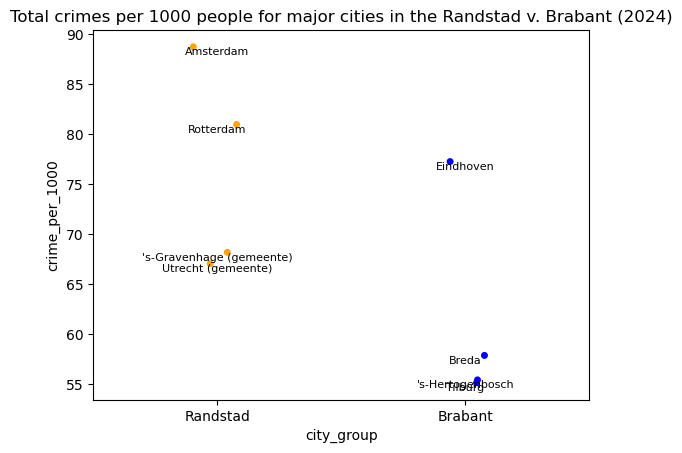

In [58]:
## Strip plot comparing total crime per city in each group for 2024
ax = sns.stripplot(data=bvrgroups_2024,
            x='city_group',
            y='crime_per_1000',
            hue='city_group',
                  jitter=True,
                  palette=['orange','blue'])

## Create city name labels for each point
for i, row in bvrgroups_2024.iterrows():
    ax.text(
        x=row['city_group'],  # x position (categorical, so use the category directly)
        y=row['crime_per_1000'],  # y position
        s=row['region'],  # Label from the 'time' column (replace with 'region' for your data)
        ha="center",
        va="top",
        fontsize=8)

plt.title('Total crimes per 1000 people for major cities in the Randstad v. Brabant (2024)')
plt.show()

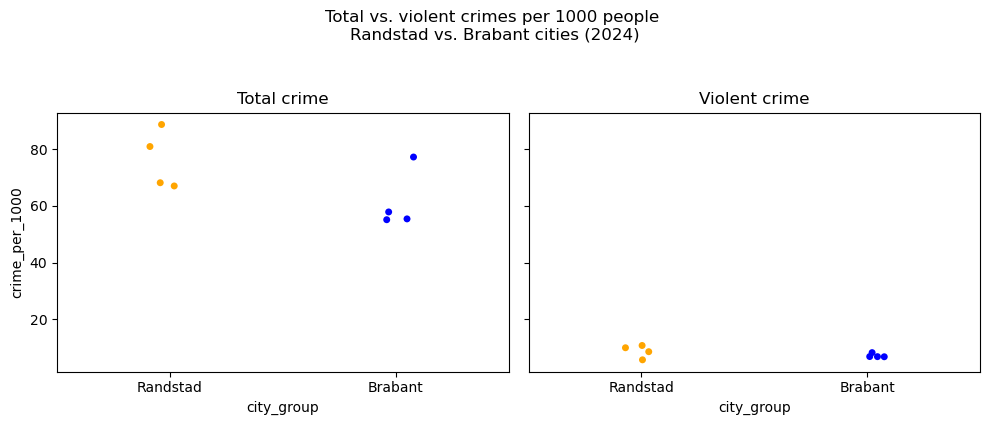

In [75]:
## Dual strip plot showing total crime vs. violent crime differences between major cities in Brabant v. Randstad

## Set figure properties
f, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(width_ratios=[4, 4]), sharex=True)


## Strip plot comparing total crime per city in each group for 2024
ax = sns.stripplot(data=bvrgroups_2024,
            x='city_group',
            y='crime_per_1000',
            hue='city_group',
                  jitter=True,
                  ax=axs[0],
                  legend=False,
                  palette=['orange','blue'])

## Strip plot comparing violent crime per city in each group for 2024
ax = sns.stripplot(data=bvrviolent_2024,
            x='city_group',
            y='violentcrime_per_1000',
            hue='city_group',
                  jitter=True,
                  ax=axs[1],
                  legend=False,
                  palette=['orange','blue'])

## Plot 2024 total crime levels for Randstad v. Brabant
# for i, row in bvrgroups_2024.iterrows():
#     ax[0].text(
#         x=row['city_group'],  # x position (categorical, so use the category directly)
#         y=row['crime_per_1000'],  # y position
#         s=row['region'],  # Label from the 'time' column (replace with 'region' for your data)
#         ha="center",
#         va="top",
#         fontsize=8)

# ## Plot 2024 violent crime levels for Randstad v. Brabant
# for i, row in bvrviolent_2024.iterrows():
#     ax[1].text(
#         x=row['city_group'],  # x position (categorical, so use the category directly)
#         y=row['violentcrime_per_1000'],  # y position
#         s=row['region'],  # Label from the 'time' column (replace with 'region' for your data)
#         ha="center",
#         va="top",
#         fontsize=8)


# Set titles
f.suptitle('Total vs. violent crimes per 1000 people \nRandstad vs. Brabant cities (2024)', y=1.05)
axs[0].set_title('Total crime')
axs[1].set_title('Violent crime')


f.tight_layout()

# Comparing total v. violent crime

In [63]:
## Subset & group original dataframe for violent crimes by region and year
violent_df = crime_df[crime_df['crime_type'].isin(violent_crime)]
violent_df = violent_df[['region','year','crime_type','crime_count']].groupby(by=['region','year']).sum()
violent_df = violent_df.drop('crime_type', axis=1).rename(columns={'crime_count':'violent_crime_count'})
violent_df

violent_crime_count
region                   year                     
's-Gravenhage (gemeente) 2012                 6525
                         2013                 6337
                         2014                 5974
                         2015                 5344
                         2016                 5065
...                                            ...
Zwolle                   2020                  777
                         2021                  840
                         2022                  858
                         2023                  801
                         2024                  864

[4614 rows x 1 columns]

In [64]:
## Merge violent crime and population dataframes by region and period
violent_merged = violent_df.merge(popdata_long, on=['region','year'])
## Calculate violent crimes per 1000 people for each region & year
violent_merged['violentcrime_per_1000'] = round((violent_merged['violent_crime_count']/(violent_merged['population']/1000)),2)
print(f"Final rows, columns: {violent_merged.shape}")
print(f"Final number of regions included: {violent_merged['region'].nunique()}")

Final rows, columns: (3873, 5)
Final number of regions included: 298


In [65]:
## Subset final violent crime dataframe by geographic level
violent_national = violent_merged[violent_merged['region'] == 'Nederland']
violent_regional = violent_merged[violent_merged['region'].str.contains('(PV)')]
violent_gemeenten = violent_merged[(~violent_merged['region'].isin(violent_national['region'])) & (~violent_merged['region'].isin(violent_regional['region']))]

C:\Users\chels\AppData\Local\Temp\ipykernel_25084\196375059.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  violent_regional = violent_merged[violent_merged['region'].str.contains('(PV)')]


In [66]:
violent_merged

,region,year,violent_crime_count,population,violentcrime_per_1000
0,'s-Gravenhage (gemeente),2012,6525,505856,12.90
1,'s-Gravenhage (gemeente),2013,6337,508940,12.45
2,'s-Gravenhage (gemeente),2014,5974,514861,11.60
3,'s-Gravenhage (gemeente),2015,5344,519988,10.28
4,'s-Gravenhage (gemeente),2016,5065,524882,9.65
...,...,...,...,...,...
3868,Zwolle,2020,777,129840,5.98
3869,Zwolle,2021,840,130668,6.43
3870,Zwolle,2022,858,132411,6.48
3871,Zwolle,2023,801,133141,6.02


## National level over time

## Major cities over time

In [68]:
## Show violent crime for major cities; group by average over 2012-2024
violent_majorcities = violent_gemeenten[violent_gemeenten['region'].isin(major_cities)]
vmc_grouped = violent_majorcities[['region', 'year', 'violentcrime_per_1000']].groupby(by='region').mean()
vmc_grouped = (
    vmc_grouped
    .drop(columns=['year'])
    .rename(columns={'violentcrime_per_1000': 'avg_violent_crime'})
)
vmc_grouped['avg_violent_crime'] = vmc_grouped['avg_violent_crime'].round(2)
vmc_grouped.sort_values(by='avg_violent_crime',ascending=False)

,avg_violent_crime
region,
Rotterdam,11.92
Amsterdam,11.82
's-Gravenhage (gemeente),10.12
Eindhoven,9.55
Arnhem,9.38
Tilburg,8.40
Groningen (gemeente),8.39
Leeuwarden,8.18
Maastricht,8.13


## Top cities in 2024

## Violent crime in the Randstad vs. Brabant cities (2024)

In [74]:
## Subset Randstad/Brabant cities for violent crime rates in 2024
bvrviolent_2024 = bvr_violent[bvr_violent['year'] == 2024]

bvrviolent_2024.sort_values(by=['violentcrime_per_1000'], ascending=False)

,region,year,violent_crime_count,population,violentcrime_per_1000,city_group
2755,Rotterdam,2024,7206,672960,10.71,Randstad
220,Amsterdam,2024,9262,934526,9.91,Randstad
12,'s-Gravenhage (gemeente),2024,4850,568945,8.52,Randstad
1013,Eindhoven,2024,2039,249035,8.19,Brabant
571,Breda,2024,1284,188779,6.80,Brabant
3092,Tilburg,2024,1559,230357,6.77,Brabant
25,'s-Hertogenbosch,2024,1087,161530,6.73,Brabant
3196,Utrecht (gemeente),2024,2127,376757,5.65,Randstad


## !! Need to label points

# Correlations: Crime numbers v. population

In [76]:
## Check assumptions needed to calculate correlation

## Normality of features
# Shapiro-Wilk test on original data
stat, p = shapiro(gemeenten_totals['population'])
print(f"Shapiro-Wilk p-value for population: {p:.4f}")
stat, p = shapiro(gemeenten_totals['crime_per_1000'])
print(f"Shapiro-Wilk p-value for total crime per 1000: {p:.4f}")

probplot(gemeententotals_2024['population'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Normality - Population')
plt.show()

probplot(gemeententotals_2024['crime_per_1000'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Normality - Crime per 1000')
plt.show()

NameError: name 'gemeenten_totals' is not defined

In [ ]:
## Total crime vs. population (2024 levels)
gemeententotals_2024 = gemeenten_df[gemeenten_df['year'] == 2024]

# Check linearity and homoscedasticity
sns.scatterplot(data=gemeententotals_2024, x='population', y='crime_per_1000')
plt.title('Scatter Plot: Linearity and Homoscedasticity')
plt.show()

# Check for outliers
sns.boxplot(data=gemeententotals_2024[['population', 'crime_per_1000']])
plt.title('Boxplot: Outliers')
plt.show()

print('Population Outliers')
Q1 = gemeententotals_2024['population'].quantile(0.25)
Q3 = gemeententotals_2024['population'].quantile(0.75)
IQR = Q3 - Q1
outliers = gemeententotals_2024[(gemeententotals_2024['population'] < Q1 - 1.5 * IQR) | (gemeententotals_2024['population'] > Q3 + 1.5 * IQR)]
print(f"Number of population outliers: {outliers.shape[0]}")

print('Total crime per 1000 Outliers')
Q1 = gemeententotals_2024['crime_per_1000'].quantile(0.25)
Q3 = gemeententotals_2024['crime_per_1000'].quantile(0.75)
IQR = Q3 - Q1
outliers = gemeententotals_2024[(gemeententotals_2024['crime_per_1000'] < Q1 - 1.5 * IQR) | (gemeententotals_2024['crime_per_1000'] > Q3 + 1.5 * IQR)]
print(f"Number of total crime per 1000 outliers: {outliers.shape[0]}")


In [ ]:
# Standardize
scaler = StandardScaler()
gemeententotals_2024[['pop_scaled','crime1000_scaled']] = scaler.fit_transform(gemeententotals_2024[['population', 'crime_per_1000']])

# Plot
sns.regplot(
    data=gemeententotals_2024,
    x='pop_scaled',
    y='crime1000_scaled',
    line_kws={'color': 'red'}
)
plt.title('Standardized Data: Scatter Plot with Regression Line')
plt.show()

# Add correlation annotation
corr, p_val = spearmanr(gemeententotals_2024['population'], gemeententotals_2024['crime_per_1000'])
plt.text(0.05, 0.95, f"Spearman's r: {corr:.2f}", transform=plt.gca().transAxes, ha='left', va='top')


In [ ]:
## Violent crime vs. population (2024 levels); top 30 municipalities